In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
import os

In [2]:
# --- Configuration ---
# Define the path to your locally available historical data CSV file.
# This file should contain all the hourly data, ideally named 'energy_timeseries_data_hourly.csv'
# as generated by your synthetic data script initially.
LOCAL_DATA_FILE = 'complete_history_store1.csv'

# Define the date range for your EDA
# These dates should align with the data available in your LOCAL_DATA_FILE
EDA_START_DATE = datetime(2024, 1, 1, 0, 0, 0) # Start of your historical data, include time for filtering if needed
EDA_END_DATE = datetime(2025, 6, 13, 23, 59, 59)   # End of your historical data (or latest date available)


In [3]:
# --- 1. Load Data from Local CSV ---
print(f"--- Loading Historical Data for EDA from {LOCAL_DATA_FILE} ---")
try:
    if not os.path.exists(LOCAL_DATA_FILE):
        print(f"Error: Local data file '{LOCAL_DATA_FILE}' not found.")
        print("Please ensure the 'energy_timeseries_data_hourly.csv' file is in the same directory as this script.")
        exit()

    df = pd.read_csv(LOCAL_DATA_FILE)

    if df.empty:
        print("No data loaded for EDA. The CSV file is empty.")
        exit()

    # Ensure timestamp is datetime and filter by date range
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Filter DataFrame by the specified date range
    df = df[(df['timestamp'] >= EDA_START_DATE) & (df['timestamp'] <= EDA_END_DATE)]

    if df.empty:
        print(f"No data found within the specified date range: {EDA_START_DATE} to {EDA_END_DATE}.")
        exit()

    # Set timestamp as index for time series operations
    df = df.set_index('timestamp')


    print(f"Successfully loaded {len(df)} rows for EDA within the specified range.")
    print("\nDataFrame Info:")
    df.info()
    print("\nDataFrame Head:")
    print(df.head().to_string())
except Exception as e:
    print(f"Failed to load historical data from local file: {e}")
    exit()

--- Loading Historical Data for EDA from complete_history_store1.csv ---
Successfully loaded 12720 rows for EDA within the specified range.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12720 entries, 2024-01-01 00:00:00 to 2025-06-13 23:00:00
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HVAC_Energy(t)                   12720 non-null  float64
 1   Refrigeration_Energy(t)          12720 non-null  float64
 2   Lighting_Energy(t)               12720 non-null  float64
 3   IT_System(t)                     12720 non-null  float64
 4   Other_System(t)                  12720 non-null  float64
 5   Electricity_Price(t)             12720 non-null  float64
 6   Solar_Available_for_Use(t)       12720 non-null  float64
 7   Solar_Used_to_Charge_Battery(t)  12720 non-null  float64
 8   Base_Consumption_Loads(t)        12720 non-null  float64
 9   Total_Energy

In [4]:
# --- 2. Feature Engineering (Time-based factors) ---
print("\n--- Feature Engineering ---")
df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6
df['day_name'] = df.index.day_name()
df['month'] = df.index.month
df['month_name'] = df.index.month_name()
df['year'] = df.index.year
df['quarter'] = df.index.quarter
# Simple season mapping (adjust as per your geographical context if needed)
def get_season(month):
    if 3 <= month <= 5: return 'Spring'
    elif 6 <= month <= 8: return 'Summer'
    elif 9 <= month <= 11: return 'Autumn'
    else: return 'Winter'
df['season'] = df['month'].apply(get_season)

print("Added time-based features: hour_of_day, day_of_week, month, year, quarter, season.")
print(df[['hour_of_day', 'day_of_week', 'month', 'season']].head())


--- Feature Engineering ---
Added time-based features: hour_of_day, day_of_week, month, year, quarter, season.
                     hour_of_day  day_of_week  month  season
timestamp                                                   
2024-01-01 00:00:00            0            0      1  Winter
2024-01-01 01:00:00            1            0      1  Winter
2024-01-01 02:00:00            2            0      1  Winter
2024-01-01 03:00:00            3            0      1  Winter
2024-01-01 04:00:00            4            0      1  Winter


In [5]:
# --- 3. Basic Statistics ---
print("\n--- Basic Descriptive Statistics ---")
print(df.describe().to_string())


--- Basic Descriptive Statistics ---
       HVAC_Energy(t)  Refrigeration_Energy(t)  Lighting_Energy(t)  IT_System(t)  Other_System(t)  Electricity_Price(t)  Solar_Available_for_Use(t)  Solar_Used_to_Charge_Battery(t)  Base_Consumption_Loads(t)  Total_Energy(t)  Battery_1_Charge_Discharge(t)  Battery_1_Energy_Stored(t)  Battery_2_Charge_Discharge(t)  Battery_2_Energy_Stored(t)   hour_of_day   day_of_week         month          year       quarter
count    12720.000000             12720.000000        12720.000000  12720.000000     12720.000000          12720.000000                12720.000000                     12720.000000               12720.000000     12720.000000                   12720.000000                12720.000000                   12720.000000                12720.000000  12720.000000  12720.000000  12720.000000  12720.000000  12720.000000
mean       170.721940               200.895255           59.014057     79.966992        50.035059              0.110195                 


--- Generating Overall Time Series Plots ---


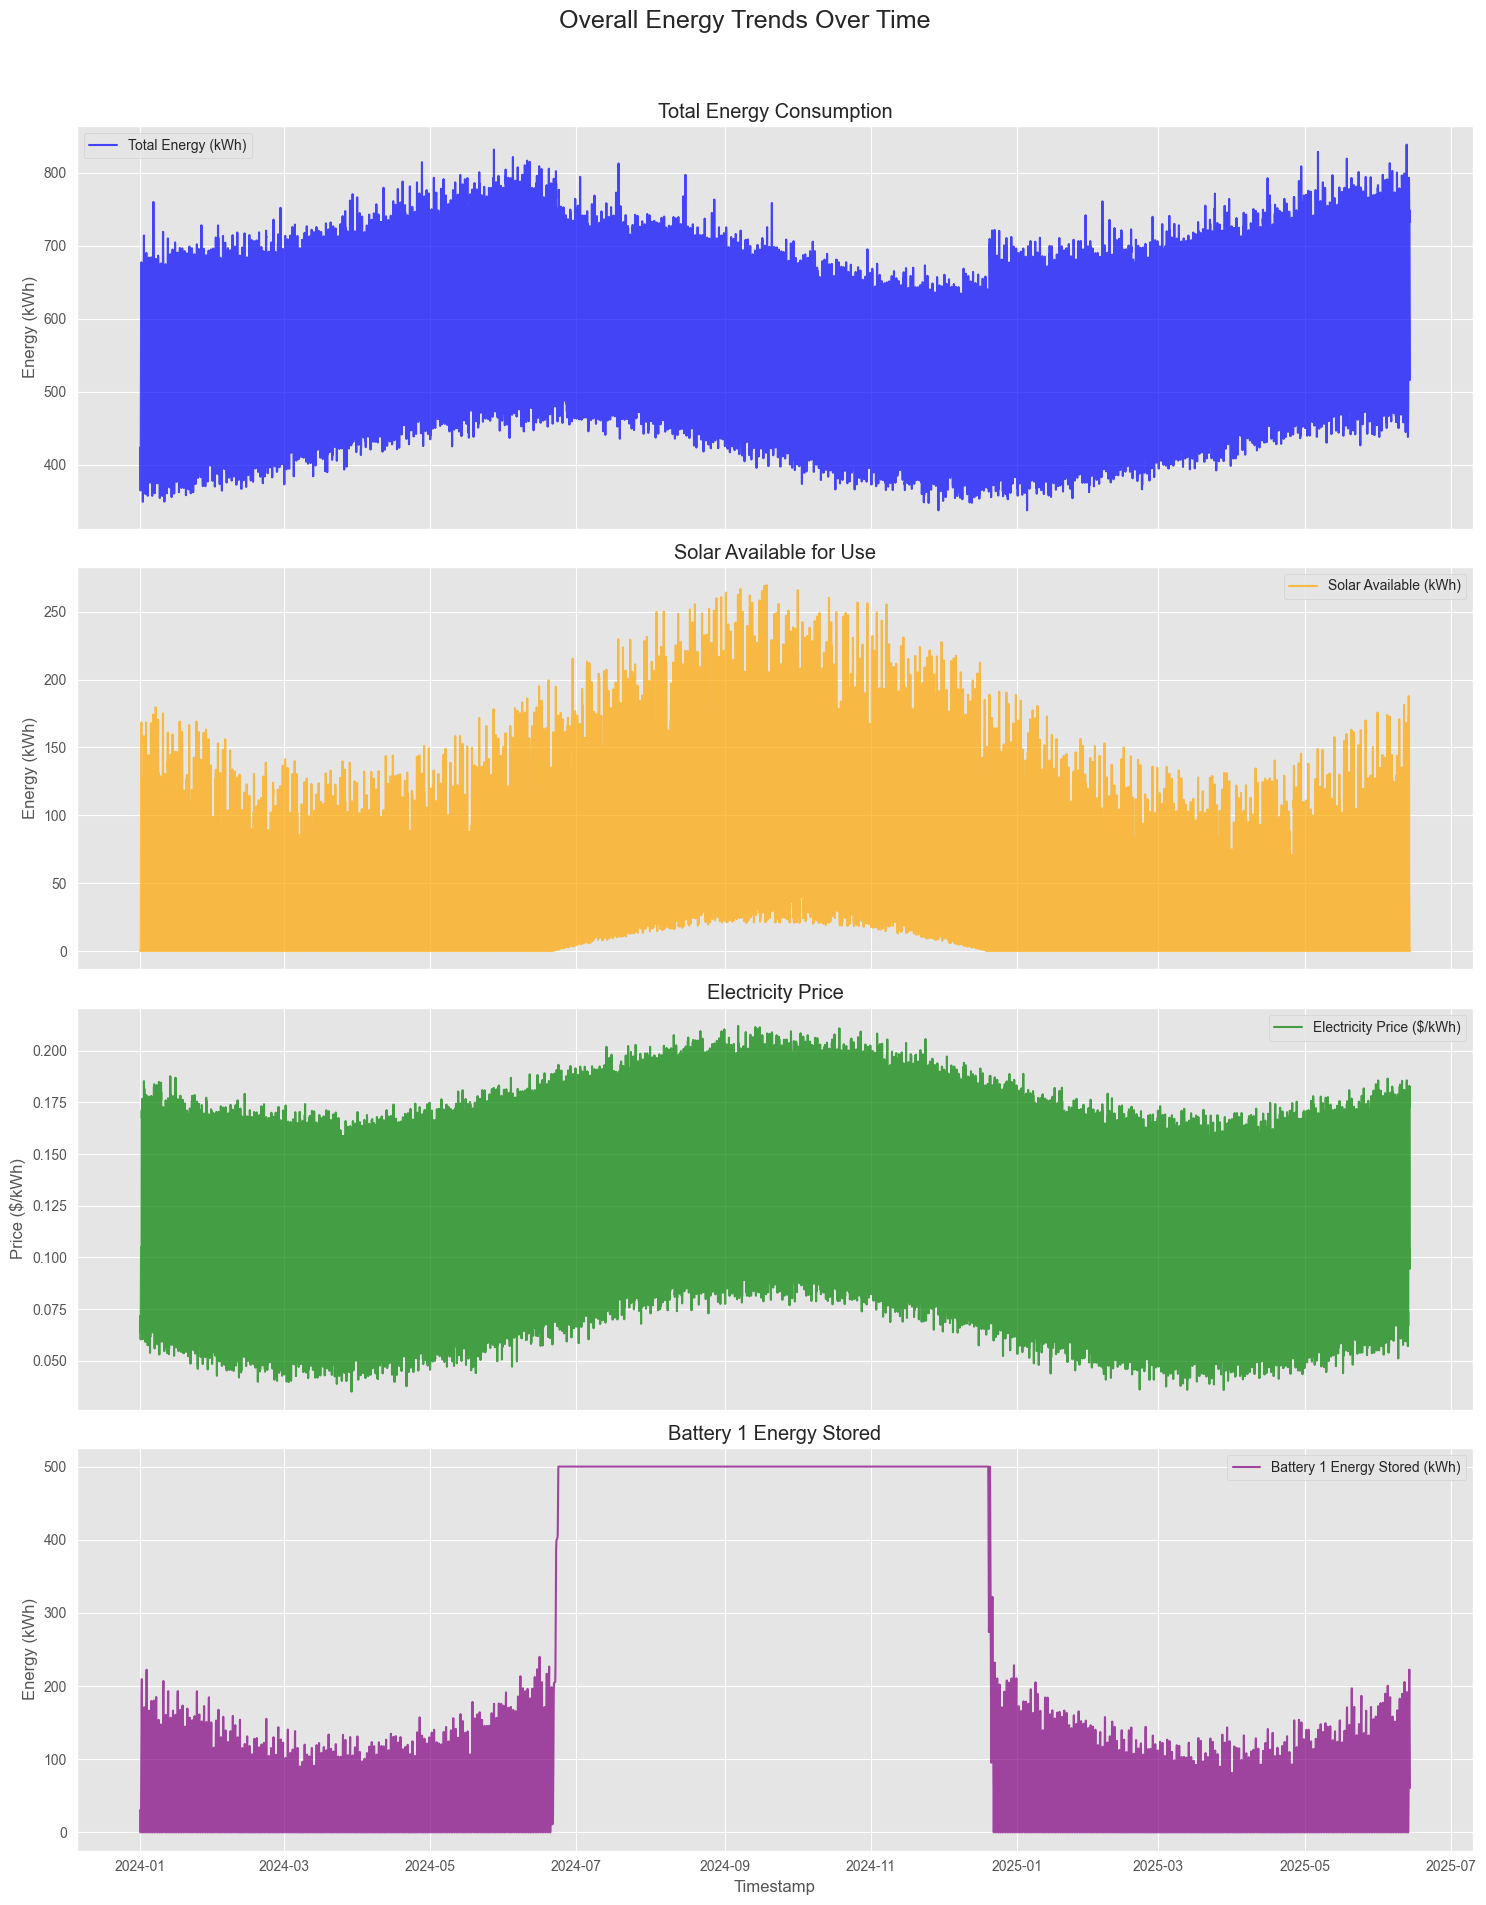

In [6]:
# --- 4. Time Series Plots ---

# Set a style for the plots
sns.set_style("whitegrid")
plt.style.use('ggplot')

# Plot overall trends for key metrics
print("\n--- Generating Overall Time Series Plots ---")
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20), sharex=True)
fig.suptitle('Overall Energy Trends Over Time', fontsize=18)

# Total Energy Consumption
axes[0].plot(df.index, df['Total_Energy(t)'], label='Total Energy (kWh)', color='blue', alpha=0.7)
axes[0].set_ylabel('Energy (kWh)')
axes[0].set_title('Total Energy Consumption')
axes[0].legend()

# Solar Available for Use
axes[1].plot(df.index, df['Solar_Available_for_Use(t)'], label='Solar Available (kWh)', color='orange', alpha=0.7)
axes[1].set_ylabel('Energy (kWh)')
axes[1].set_title('Solar Available for Use')
axes[1].legend()

# Electricity Price
axes[2].plot(df.index, df['Electricity_Price(t)'], label='Electricity Price ($/kWh)', color='green', alpha=0.7)
axes[2].set_ylabel('Price ($/kWh)')
axes[2].set_title('Electricity Price')
axes[2].legend()

# Battery 1 Energy Stored
axes[3].plot(df.index, df['Battery_1_Energy_Stored(t)'], label='Battery 1 Energy Stored (kWh)', color='purple', alpha=0.7)
axes[3].set_ylabel('Energy (kWh)')
axes[3].set_title('Battery 1 Energy Stored')
axes[3].legend()

plt.xlabel('Timestamp')
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()


--- Analyzing Patterns by Time of Day, Day of Week, and Month ---


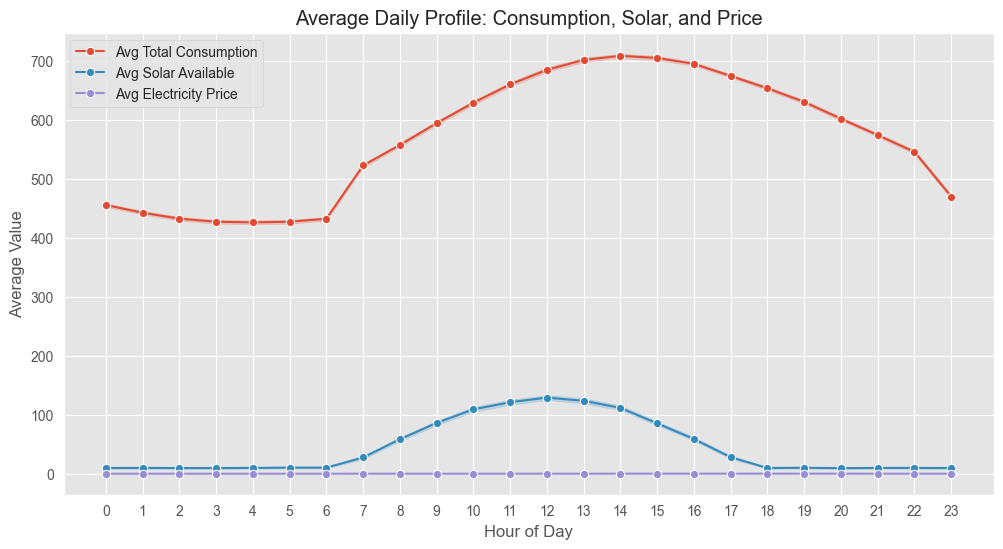

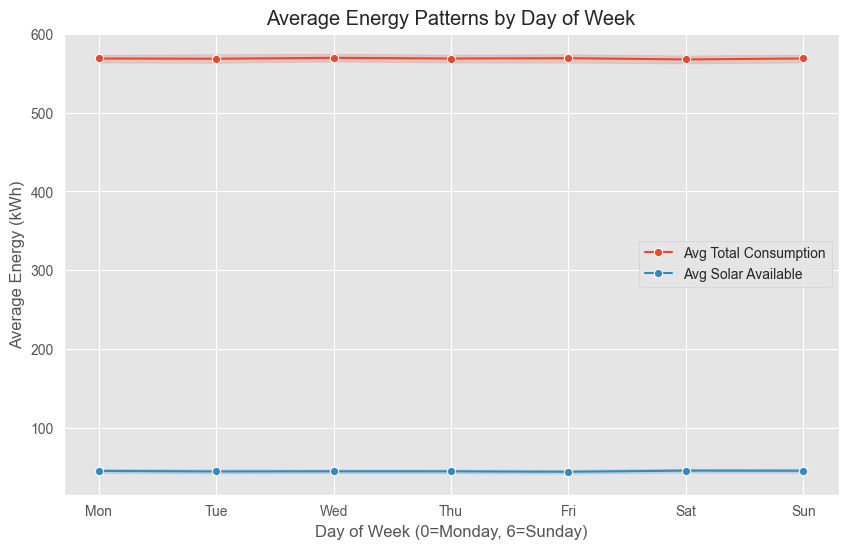

C:\Users\Ratnesh Jaiswal\AppData\Local\Temp\ipykernel_16220\1007796817.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='month_name', y='Total_Energy(t)', estimator=np.mean, ci='sd', palette='viridis', label='Avg Total Consumption')
C:\Users\Ratnesh Jaiswal\AppData\Local\Temp\ipykernel_16220\1007796817.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='month_name', y='Total_Energy(t)', estimator=np.mean, ci='sd', palette='viridis', label='Avg Total Consumption')
C:\Users\Ratnesh Jaiswal\AppData\Local\Temp\ipykernel_16220\1007796817.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='month_name', y='Solar_Available_for_Use(t)', estimator=np.mean, ci='sd', palette='magma', label

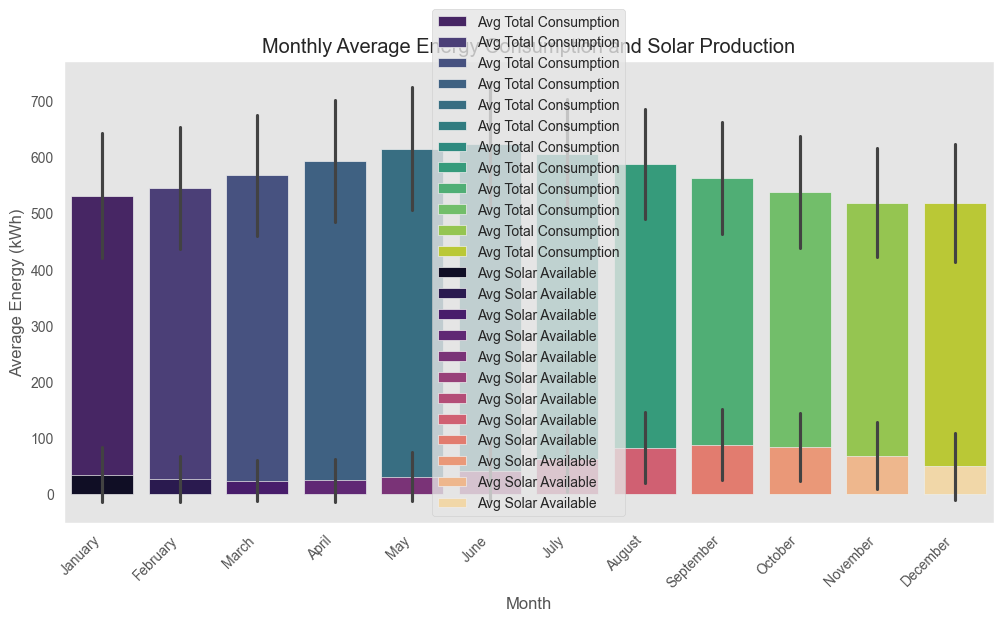

In [7]:
# --- 5. Analyze Patterns by Time Factors ---

print("\n--- Analyzing Patterns by Time of Day, Day of Week, and Month ---")

# Average Hourly Profile (Total Consumption, Solar, Price)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour_of_day', y='Total_Energy(t)', estimator=np.mean, label='Avg Total Consumption', marker='o')
sns.lineplot(data=df, x='hour_of_day', y='Solar_Available_for_Use(t)', estimator=np.mean, label='Avg Solar Available', marker='o')
sns.lineplot(data=df, x='hour_of_day', y='Electricity_Price(t)', estimator=np.mean, label='Avg Electricity Price', marker='o')
plt.title('Average Daily Profile: Consumption, Solar, and Price')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

# Average Day of Week Profile (Total Consumption, Solar)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='day_of_week', y='Total_Energy(t)', estimator=np.mean, label='Avg Total Consumption', marker='o')
sns.lineplot(data=df, x='day_of_week', y='Solar_Available_for_Use(t)', estimator=np.mean, label='Avg Solar Available', marker='o')
plt.title('Average Energy Patterns by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Energy (kWh)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.grid(True)
plt.show()

# Monthly Average for Total Consumption and Solar
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='month_name', y='Total_Energy(t)', estimator=np.mean, ci='sd', palette='viridis', label='Avg Total Consumption')
sns.barplot(data=df, x='month_name', y='Solar_Available_for_Use(t)', estimator=np.mean, ci='sd', palette='magma', label='Avg Solar Available')
plt.title('Monthly Average Energy Consumption and Solar Production')
plt.xlabel('Month')
plt.ylabel('Average Energy (kWh)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')
plt.show()


--- Correlation Analysis ---


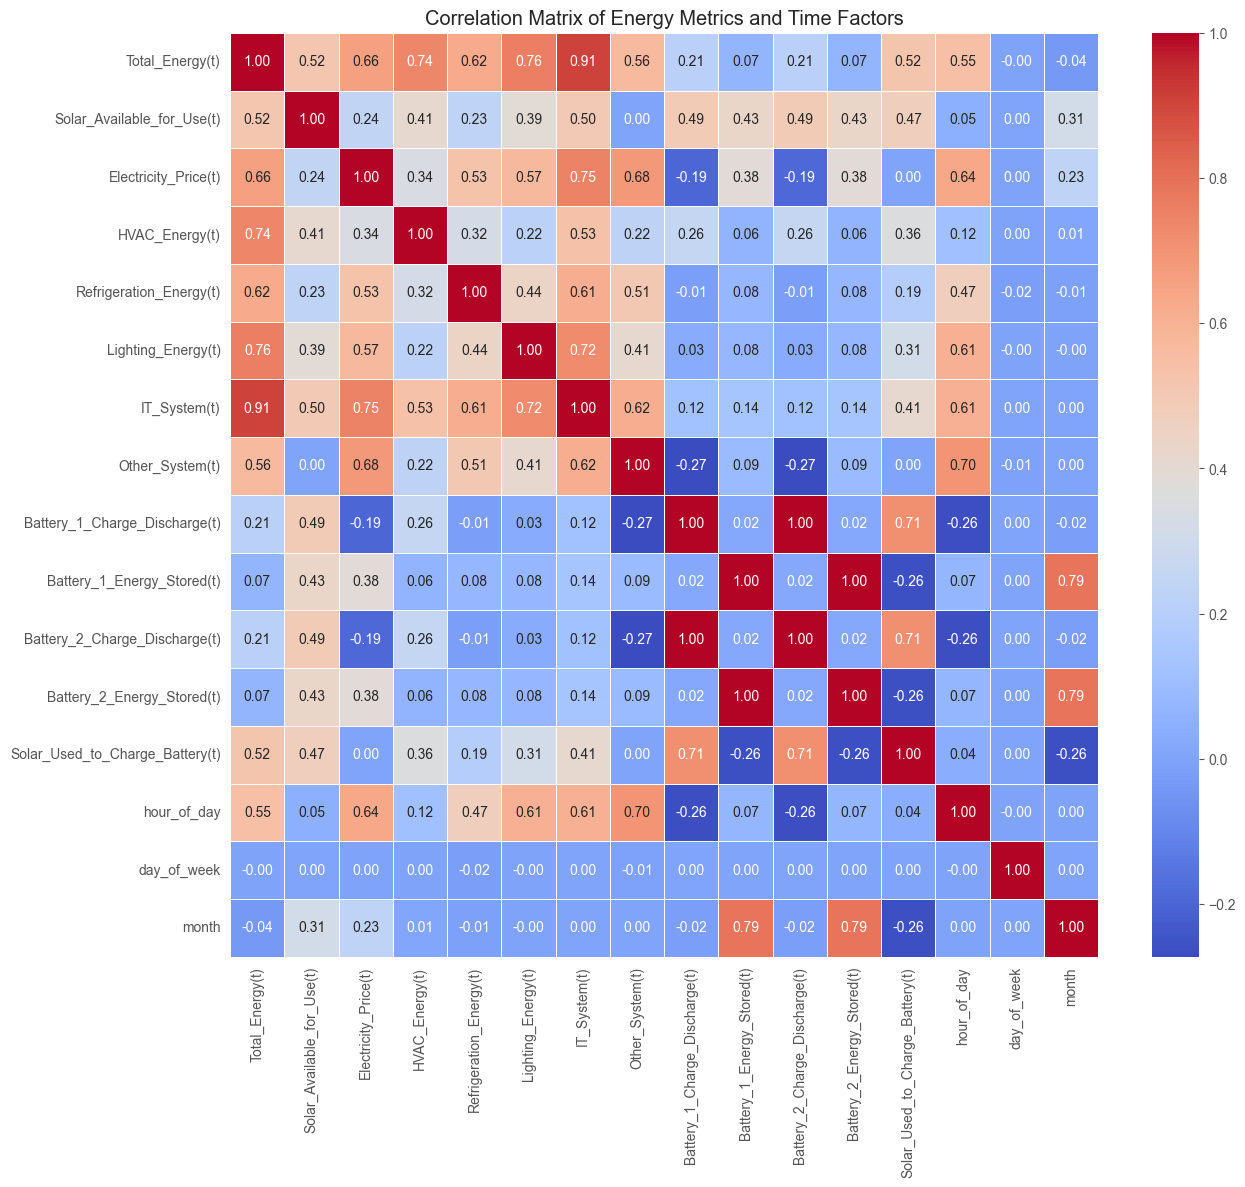


Key Correlations (manual interpretation from heatmap):
- High positive correlation between 'Total_Energy(t)' and individual consumption loads (HVAC, Refrigeration, etc.).
- 'Solar_Available_for_Use(t)' likely correlates negatively with 'hour_of_day' outside peak daylight hours.
- 'Electricity_Price(t)' may show correlation with 'hour_of_day' (peak/off-peak pricing).
- Battery charge/discharge likely correlates with solar production and energy consumption needs.


In [8]:
# --- 6. Correlation Analysis ---
print("\n--- Correlation Analysis ---")

# Select relevant numerical columns for correlation
correlation_cols = [
    'Total_Energy(t)',
    'Solar_Available_for_Use(t)',
    'Electricity_Price(t)',
    'HVAC_Energy(t)',
    'Refrigeration_Energy(t)',
    'Lighting_Energy(t)',
    'IT_System(t)',
    'Other_System(t)',
    'Battery_1_Charge_Discharge(t)',
    'Battery_1_Energy_Stored(t)',
    'Battery_2_Charge_Discharge(t)',
    'Battery_2_Energy_Stored(t)',
    'Solar_Used_to_Charge_Battery(t)',
    'hour_of_day',
    'day_of_week',
    'month'
]

# Create a correlation matrix
corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Energy Metrics and Time Factors')
plt.show()

print("\nKey Correlations (manual interpretation from heatmap):")
print("- High positive correlation between 'Total_Energy(t)' and individual consumption loads (HVAC, Refrigeration, etc.).")
print("- 'Solar_Available_for_Use(t)' likely correlates negatively with 'hour_of_day' outside peak daylight hours.")
print("- 'Electricity_Price(t)' may show correlation with 'hour_of_day' (peak/off-peak pricing).")
print("- Battery charge/discharge likely correlates with solar production and energy consumption needs.")



--- Battery Specific Analysis ---


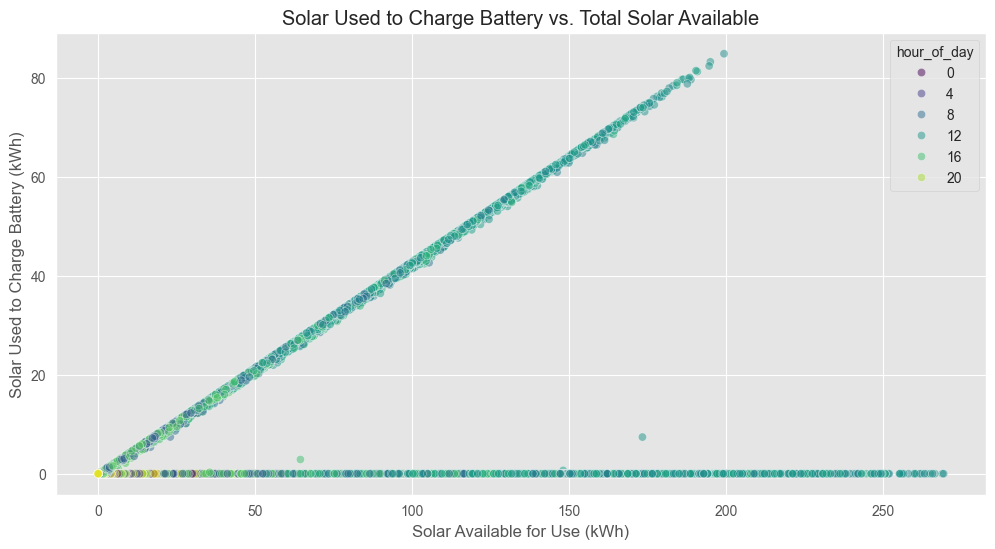

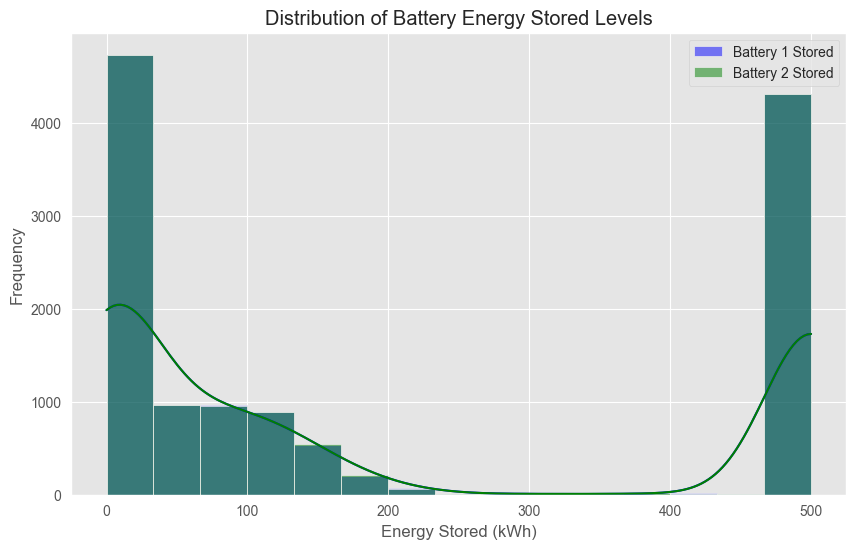

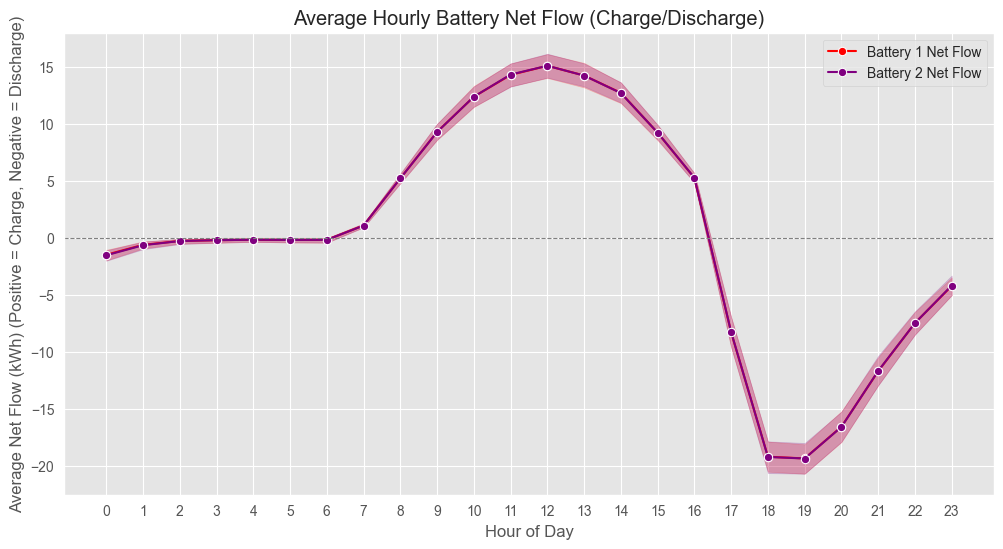


--- EDA Complete ---


In [9]:
# --- 7. Battery Specific Analysis ---
print("\n--- Battery Specific Analysis ---")

# Battery Charge/Discharge vs. Solar_Used_to_Charge_Battery
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Solar_Available_for_Use(t)', y='Solar_Used_to_Charge_Battery(t)', alpha=0.5, hue='hour_of_day', palette='viridis')
plt.title('Solar Used to Charge Battery vs. Total Solar Available')
plt.xlabel('Solar Available for Use (kWh)')
plt.ylabel('Solar Used to Charge Battery (kWh)')
plt.grid(True)
plt.show()

# Battery Energy Stored Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Battery_1_Energy_Stored(t)'], kde=True, color='blue', label='Battery 1 Stored')
sns.histplot(df['Battery_2_Energy_Stored(t)'], kde=True, color='green', label='Battery 2 Stored')
plt.title('Distribution of Battery Energy Stored Levels')
plt.xlabel('Energy Stored (kWh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Average Battery Charge/Discharge by Hour of Day
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour_of_day', y='Battery_1_Charge_Discharge(t)', estimator=np.mean, label='Battery 1 Net Flow', marker='o', color='red')
sns.lineplot(data=df, x='hour_of_day', y='Battery_2_Charge_Discharge(t)', estimator=np.mean, label='Battery 2 Net Flow', marker='o', color='purple')
plt.title('Average Hourly Battery Net Flow (Charge/Discharge)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Net Flow (kWh) (Positive = Charge, Negative = Discharge)')
plt.xticks(range(24))
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line
plt.legend()
plt.grid(True)
plt.show()

print("\n--- EDA Complete ---")